# Imports and Setup


In [ ]:
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [ ]:
! pip install numpy pystoi==0.3.3 six sounddevice==0.4.0 torchaudio>=0.5.1 torch>=1.5.1+cu101 --extra-index-url https://download.pytorch.org/whl/cu101 pydub

In [ ]:
! pip install git+https://github.com/ludlows/python-pesq#egg=pesq

  Cloning https://github.com/ludlows/python-pesq to /tmp/pip-install-4fzz47nt/pesq_3fca608e8c3e4665a9c2a56b3253c945
  Running command git clone --filter=blob:none --quiet https://github.com/ludlows/python-pesq /tmp/pip-install-4fzz47nt/pesq_3fca608e8c3e4665a9c2a56b3253c945
  Resolved https://github.com/ludlows/python-pesq to commit 5e230c59a3272fa80d8a6ea0d1e623f3fa560731
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262405 sha256=13831b72ac2ae06a259a248393ea8fa7c569a5f8e403f206b8ffef33cdeeb8b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpdt7ecu/wheels/ff/e8/c2/f766b3bdd814052536d14877017112e2e1ce3d918fe0e15611
Successfully built pesq


In [ ]:
! pip install torch-summary

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
# from matplotlib import image
import glob as glob
# from PIL import Image

import torch
import torchaudio
# import torchvision
# from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchaudio Version: ", torchaudio.__version__)
# print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.1.0+cu118
Torchaudio Version:  2.1.0+cu118
Using the GPU!


# Model Structure
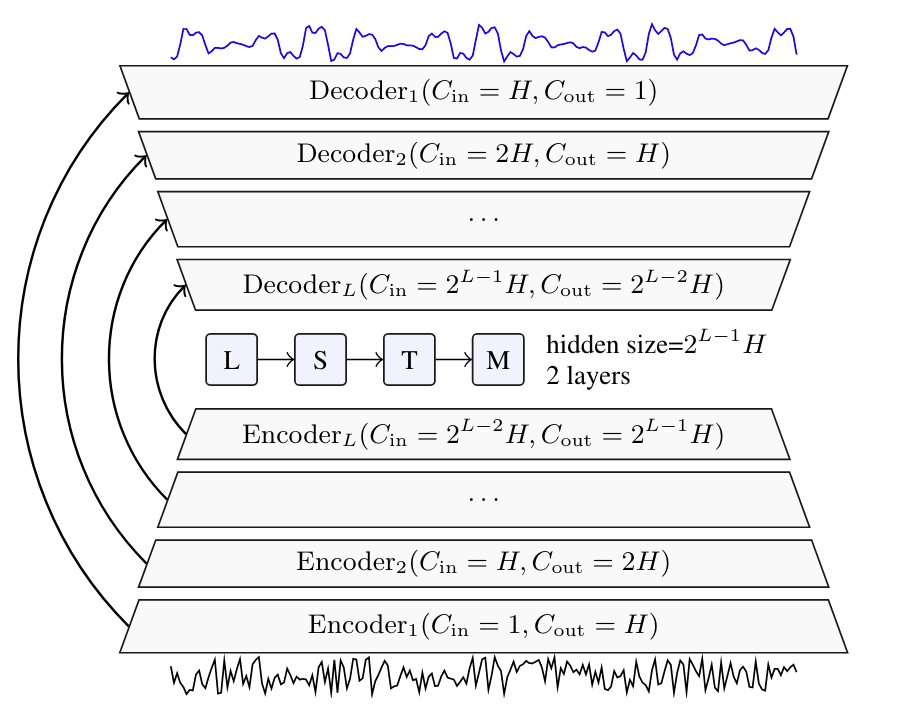

# Data, what am I doing

In [ ]:
# import librosa

In [ ]:
!rm -r noisy_testset_wav clean_testset_wav
!unzip -q "/content/drive/MyDrive/Colab Notebooks/datasets/noisy_testset_wav.zip"
!unzip -q "/content/drive/MyDrive/Colab Notebooks/datasets/clean_testset_wav.zip"

rm: cannot remove 'noisy_testset_wav': No such file or directory
rm: cannot remove 'clean_testset_wav': No such file or directory


In [ ]:
!rm -r cleanraw produced
!unzip -q "/content/drive/MyDrive/Colab Notebooks/datasets/cleanraw.zip"
!unzip -q "/content/drive/MyDrive/Colab Notebooks/datasets/produced.zip"

rm: cannot remove 'cleanraw': No such file or directory
rm: cannot remove 'produced': No such file or directory


### Valentini

In [ ]:
!rmdir ./noisy_test ./noisy_train ./clean_test ./clean_train
!mkdir ./noisy_test
!mkdir ./noisy_train
!mkdir ./clean_test
!mkdir ./clean_train

rmdir: failed to remove './noisy_test': No such file or directory
rmdir: failed to remove './noisy_train': No such file or directory
rmdir: failed to remove './clean_test': No such file or directory
rmdir: failed to remove './clean_train': No such file or directory


In [ ]:
# arbitrary train test splits, decided not to randomize because it's easier to qualitatively assess this way and randomization doesn't make a huge difference
test_idxs = np.arange(1, 416, 5)
test_idxs = list(test_idxs)

In [ ]:
test_idxs2 = np.arange(1, 435, 5)
test_idxs2 = list(test_idxs2)

In [ ]:
import shutil

In [ ]:
# extremely sloppy method of dealing with dataloaders because dealing with torch samplers is a pain for now
noisyroot = './noisy_testset_wav/'
cleanroot = './clean_testset_wav/'
noisytest = './noisy_test/'
noisytrain = './noisy_train/'
cleantest = './clean_test/'
cleantrain = './clean_train/'
for i in range(1, 416):
  file = f'p232_{i:03d}.wav'
  if not os.path.isfile(noisyroot + file):
    continue
  if i in test_idxs:
    shutil.copy(noisyroot + file, noisytest + file)
    shutil.copy(cleanroot + file, cleantest + file)
  else:
    shutil.copy(noisyroot + file, noisytrain + file)
    shutil.copy(cleanroot + file, cleantrain + file)

In [ ]:
for i in range(1, 435):
  file = f'p257_{i:03d}.wav'
  if not os.path.isfile(noisyroot + file):
    continue
  if i in test_idxs2:
    shutil.copy(noisyroot + file, noisytest + file)
    shutil.copy(cleanroot + file, cleantest + file)
  else:
    shutil.copy(noisyroot + file, noisytrain + file)
    shutil.copy(cleanroot + file, cleantrain + file)

### DAPS

In [ ]:
# short clips dataset and longer clips dataset, one for combined use with Valentini-trained models
!rm -r daps_raw_strain daps_raw_stest daps_prod_strain daps_prod_stest
!rm -r daps_raw_ltrain daps_raw_ltest daps_prod_ltrain daps_prod_ltest
!mkdir daps_raw_strain daps_raw_stest daps_prod_strain daps_prod_stest
!mkdir daps_raw_ltrain daps_raw_ltest daps_prod_ltrain daps_prod_ltest

rm: cannot remove 'daps_raw_strain': No such file or directory
rm: cannot remove 'daps_raw_stest': No such file or directory
rm: cannot remove 'daps_prod_strain': No such file or directory
rm: cannot remove 'daps_prod_stest': No such file or directory
rm: cannot remove 'daps_raw_ltrain': No such file or directory
rm: cannot remove 'daps_raw_ltest': No such file or directory
rm: cannot remove 'daps_prod_ltrain': No such file or directory
rm: cannot remove 'daps_prod_ltest': No such file or directory


In [ ]:
# sample portions of long recordings...
torchaudio.info("./cleanraw/f10_script1_cleanraw.wav").sample_rate, torchaudio.info("./cleanraw/f10_script1_cleanraw.wav").num_frames

(44100, 7609066)

In [ ]:
len(os.listdir('./cleanraw'))

100

In [ ]:
from pydub import AudioSegment

noisyroot = './cleanraw/'
cleanroot = './produced/'
noisytest = './daps_raw_ltest/'
noisytrain = './daps_raw_ltrain/'
cleantest = './daps_prod_ltest/'
cleantrain = './daps_prod_ltrain/'

shortnoisytest = './daps_raw_stest/'
shortnoisytrain = './daps_raw_strain/'
shortcleantest = './daps_prod_stest/'
shortcleantrain = './daps_prod_strain/'


noisyfiles = os.listdir(noisyroot)
cleanfiles = os.listdir(cleanroot)
test_idxs = list(np.arange(1, len(noisyfiles), 5))
time = 2 * 1000

if len(noisyfiles) != len(cleanfiles): print("File counts not matching")
for i in range(len(noisyfiles)):
  nf = noisyfiles[i]
  cf = '_'.join(nf.split('_')[0:2]) + '_produced.wav'
  if not os.path.isfile(noisyroot + nf) or not os.path.isfile(cleanroot + cf):
    continue


  noisyaudio = AudioSegment.from_wav(noisyroot + nf)
  cleanaudio = AudioSegment.from_wav(cleanroot + cf)

  if i in test_idxs:
    shutil.copy(noisyroot + nf, noisytest + nf)
    shutil.copy(cleanroot + cf, cleantest + cf)

    for j in range(1, 15, 3):
      start = j * 1000
      nnew = noisyaudio[start:start + time]
      cnew = cleanaudio[start:start + time]
      nnew.export(shortnoisytest + f'{j}_' + nf, format='wav')
      cnew.export(shortcleantest + f'{j}_' + cf, format='wav')
  else:
    shutil.copy(noisyroot + nf, noisytrain + nf)
    shutil.copy(cleanroot + cf, cleantrain + cf)
    # print(f'{nf}, {cf}')

    for k in range(1, 15, 3):
      start = k * 1000
      nnew = noisyaudio[start:start + time]
      cnew = cleanaudio[start:start + time]
      nnew.export(shortnoisytrain + f'{k}_' + nf, format='wav')
      cnew.export(shortcleantrain + f'{k}_' + cf, format='wav')

### Sudden sounds

In [ ]:
# 100032 - dog
# 100038 - birds
# 100210 - vacuum
# 104089 - clap
# 118559 - water
# 13613 - clock
# 24074 - horn
!rm -r sudden
!mkdir sudden
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/sudden.zip' -d sudden

rm: cannot remove 'sudden': No such file or directory
Archive:  /content/drive/My Drive/Colab Notebooks/datasets/sudden.zip
  inflating: sudden/1-100032-A-0.wav  
  inflating: sudden/1-100038-A-14.wav  
  inflating: sudden/1-100210-A-36.wav  
  inflating: sudden/1-104089-A-22.wav  
  inflating: sudden/1-118559-A-17.wav  
  inflating: sudden/1-13613-A-37.wav  
  inflating: sudden/1-24074-A-43.wav  


In [ ]:
!rm -r env_ntest env_ntrain env_ctest env_ctrain
!mkdir env_ntest env_ntrain
!mkdir env_ctest env_ctrain

noisy_targets = os.listdir('./noisy_train')[:100]
clean_targets = os.listdir('./clean_train')[:100]
sound_targets = [(f, AudioSegment.from_wav('./sudden/' + f)) for f in os.listdir('./sudden')]
for nfile, cfile in zip(noisy_targets, clean_targets):
  norig = AudioSegment.from_wav('./noisy_train/' + nfile)
  corig = AudioSegment.from_wav('./clean_train/' + cfile)
  for f, clip in sound_targets:
    pref = f.split('-')[1] + '_'
    nclip = norig.overlay(clip)
    cclip = corig[:len(nclip)]
    nclip.export('./env_ntrain/' + pref + nfile, format='wav')
    cclip.export('./env_ctrain/' + pref + cfile, format='wav')


noisy_targets = os.listdir('./noisy_test')[:20]
clean_targets = os.listdir('./clean_test')[:20]
for nfile, cfile in zip(noisy_targets, clean_targets):
  norig = AudioSegment.from_wav('./noisy_test/' + nfile)
  corig = AudioSegment.from_wav('./clean_test/' + cfile)
  for f, clip in sound_targets:
    pref = f.split('-')[1] + '_'
    nclip = norig.overlay(clip)
    cclip = corig[:len(nclip)]
    nclip.export('./env_ntest/' + pref + nfile, format='wav')
    cclip.export('./env_ctest/' + pref + cfile, format='wav')

rm: cannot remove 'env_ntest': No such file or directory
rm: cannot remove 'env_ntrain': No such file or directory
rm: cannot remove 'env_ctest': No such file or directory
rm: cannot remove 'env_ctrain': No such file or directory


### People sounds

In [ ]:
# 22694 - baby
# 26143 - sneezing
# 27403 - snoring
# 30709 - breathing
# 30830 - coughing
!rm -r human
!mkdir human
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/human.zip' -d human

rm: cannot remove 'human': No such file or directory
Archive:  /content/drive/My Drive/Colab Notebooks/datasets/human.zip
  inflating: human/1-22694-A-20.wav  
  inflating: human/1-26143-A-21.wav  
  inflating: human/1-27403-A-28.wav  
  inflating: human/1-30709-A-23.wav  
  inflating: human/1-30830-A-24.wav  


In [ ]:
!rm -r hum_ntest hum_ntrain hum_ctest hum_ctrain
!mkdir hum_ntest hum_ntrain
!mkdir hum_ctest hum_ctrain

noisy_targets = os.listdir('./noisy_train')[:100]
clean_targets = os.listdir('./clean_train')[:100]
sound_targets = [(f, AudioSegment.from_wav('./sudden/' + f)) for f in os.listdir('./sudden')]
for nfile, cfile in zip(noisy_targets, clean_targets):
  norig = AudioSegment.from_wav('./noisy_train/' + nfile)
  corig = AudioSegment.from_wav('./clean_train/' + cfile)
  for f, clip in sound_targets:
    pref = f.split('-')[1] + '_'
    nclip = norig.overlay(clip)
    cclip = corig[:len(nclip)]
    nclip.export('./hum_ntrain/' + pref + nfile, format='wav')
    cclip.export('./hum_ctrain/' + pref + cfile, format='wav')


noisy_targets = os.listdir('./noisy_test')[:20]
clean_targets = os.listdir('./clean_test')[:20]
for nfile, cfile in zip(noisy_targets, clean_targets):
  norig = AudioSegment.from_wav('./noisy_test/' + nfile)
  corig = AudioSegment.from_wav('./clean_test/' + cfile)
  for f, clip in sound_targets:
    pref = f.split('-')[1] + '_'
    nclip = norig.overlay(clip)
    cclip = corig[:len(nclip)]
    nclip.export('./hum_ntest/' + pref +nfile, format='wav')
    cclip.export('./hum_ctest/' + pref +cfile, format='wav')

rm: cannot remove 'hum_ntest': No such file or directory
rm: cannot remove 'hum_ntrain': No such file or directory
rm: cannot remove 'hum_ctest': No such file or directory
rm: cannot remove 'hum_ctrain': No such file or directory


### Preview to test torchaudio

In [ ]:
wave1, sr1 = torchaudio.load('./clean_testset_wav/p232_001.wav')
wave1.shape

torch.Size([1, 83582])

In [ ]:
# Copied helper function from Facebook denoiser
!pip install julius
import julius

def convert_audio_channels(wav, channels=2):
    """Convert audio to the given number of channels."""
    *shape, src_channels, length = wav.shape
    if src_channels == channels:
        pass
    elif channels == 1:
        # Case 1:
        # The caller asked 1-channel audio, but the stream have multiple
        # channels, downmix all channels.
        wav = wav.mean(dim=-2, keepdim=True)
    elif src_channels == 1:
        # Case 2:
        # The caller asked for multiple channels, but the input file have
        # one single channel, replicate the audio over all channels.
        wav = wav.expand(*shape, channels, length)
    elif src_channels >= channels:
        # Case 3:
        # The caller asked for multiple channels, and the input file have
        # more channels than requested. In that case return the first channels.
        wav = wav[..., :channels, :]
    else:
        # Case 4: What is a reasonable choice here?
        raise ValueError('The audio file has less channels than requested but is not mono.')
    return wav

def convert_audio(wav, from_samplerate, to_samplerate, channels):
    """Convert audio from a given samplerate to a target one and target number of channels."""
    wav = convert_audio_channels(wav, channels)
    return julius.resample_frac(wav, from_samplerate, to_samplerate)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21870 sha256=e9083cf22231ae176cd55330c65b0d6fff5528f05bd2ac8b64012352bbdb7fde
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [ ]:
wave2 = convert_audio(wave1, sr1, 16000, 1)
wave2.shape

torch.Size([1, 27860])

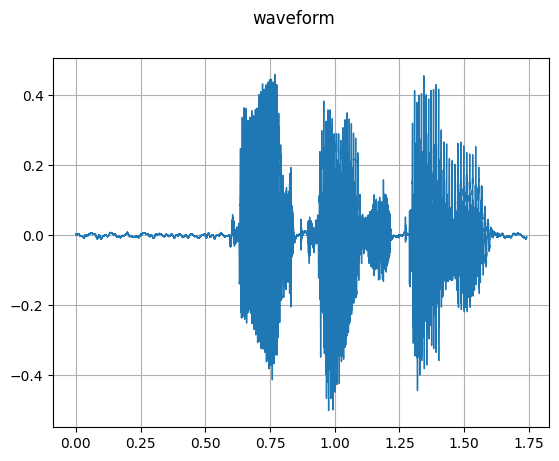

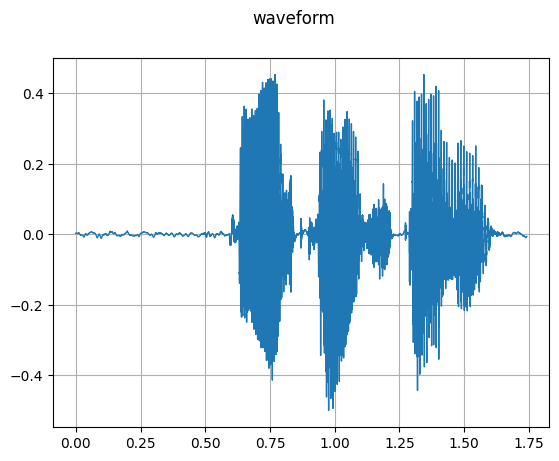

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    n_channels, n_frames = waveform.shape
    time_axis = torch.arange(0, n_frames) / sample_rate

    fig, axes = plt.subplots(n_channels, 1)
    if n_channels == 1:
        axes = [axes]
    for c in range(n_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if n_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    fig.suptitle("waveform")
    plt.show(block=False)


plot_waveform(wave1, sr1)
plot_waveform(wave2, 16000)

In [ ]:
torchaudio.info('./clean_testset_wav/p232_001.wav').sample_rate

48000

In [ ]:
torchaudio.save('/content/drive/My Drive/Colab Notebooks/small.wav', wave2, 16000)

In [ ]:
# daps_sample1, s1 = torchaudio.load('./daps_raw_ltrain/f10_script2_cleanraw.wav')
# daps_sample2, s2 = torchaudio.load('./daps_prod_ltrain/f10_script2_produced.wav')
# plot_waveform(daps_sample1, s1)
# plot_waveform(daps_sample2, s2)

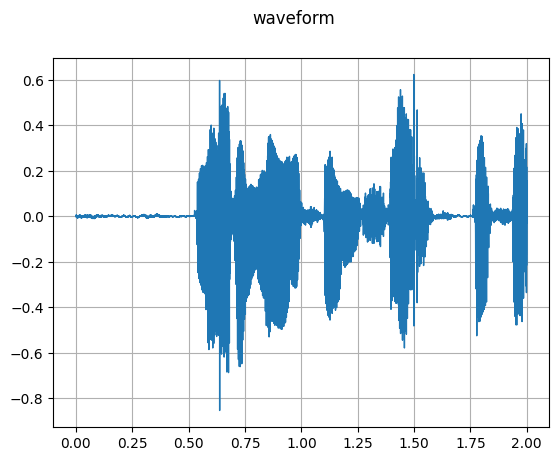

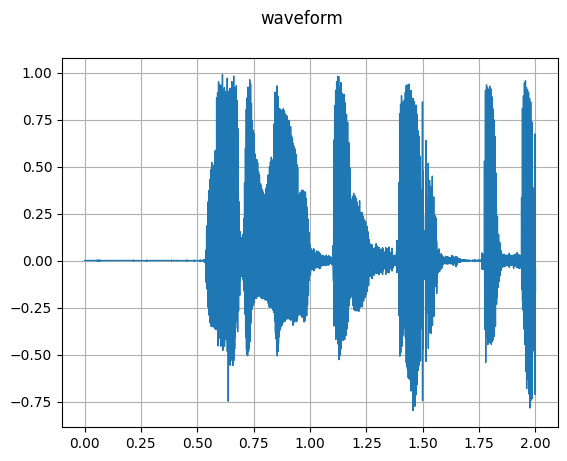

In [ ]:
daps_sample3, s3 = torchaudio.load('./daps_raw_strain/10_f10_script2_cleanraw.wav')
daps_sample4, s4 = torchaudio.load('./daps_prod_strain/10_f10_script2_produced.wav')
plot_waveform(daps_sample3, s3)
plot_waveform(daps_sample4, s4)

In [ ]:
torchaudio.save('/content/drive/My Drive/Colab Notebooks/daps3.wav', daps_sample3, s3)
torchaudio.save('/content/drive/My Drive/Colab Notebooks/daps4.wav', daps_sample4, s4)

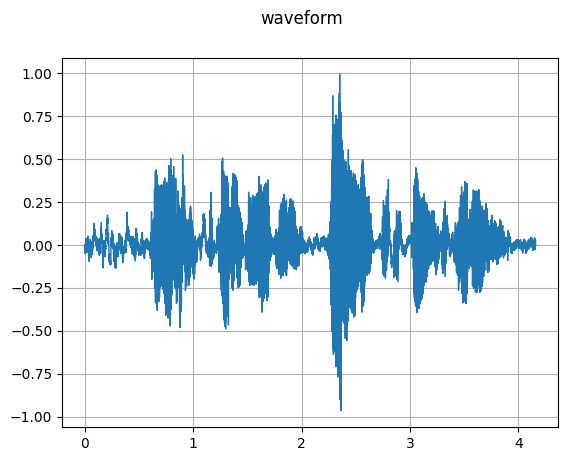

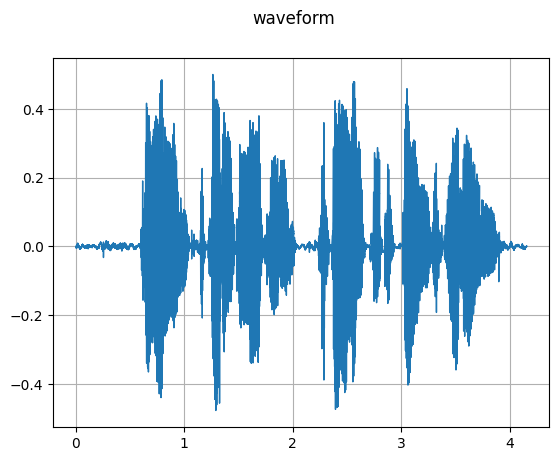

In [ ]:
env_noise, s3 = torchaudio.load('./env_ntrain/100032_p232_009.wav')
env_clean, s4 = torchaudio.load('./env_ctrain/100032_p232_009.wav')
plot_waveform(env_noise, s3)
plot_waveform(env_clean, s4)

In [ ]:
# torchaudio.save('/content/drive/My Drive/Colab Notebooks/env1.wav', env_noise, s3)
# torchaudio.save('/content/drive/My Drive/Colab Notebooks/env2.wav', env_clean, s4)

In [ ]:
torchaudio.info('./env_ntrain/100032_p232_009.wav').num_frames

199584

In [ ]:
files = os.listdir('./env_ntrain')
i = 96000
frames = []
for f in files:
  ig = torchaudio.info('./env_ntrain/' + f).num_frames
  if ig < i: i = ig
  frames.append(ig)
print(i)

59424


In [ ]:
print(np.mean(frames), (np.array(frames) > 120000).sum(), len(frames))

118140.0 329 700


### Dataloaders

In [ ]:
class AudioTmp(Dataset):
  def __init__(self, noisy_dir, clean_dir, transform=None):
    self.transform = transform
    files = os.listdir(noisy_dir)
    self.noisy = [noisy_dir + '/' + f for f in files if os.path.isfile(noisy_dir + '/' + f)]
    self.clean = [clean_dir + '/' + f for f in files if os.path.isfile(clean_dir + '/' + f)]

  def __len__(self):
    return len(self.noisy)

  def __getitem__(self, idx):
    noisy, srn = torchaudio.load(self.noisy[idx], num_frames=58000)
    clean, src = torchaudio.load(self.clean[idx], num_frames=58000)
    # noisy = convert_audio(noisy, srn, 16000, 1)
    # clean = convert_audio(clean, src, 16000, 1)
    return noisy, clean

In [ ]:
train_data = AudioTmp('./noisy_train', './clean_train')
test_data = AudioTmp('./noisy_test', './clean_test')
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
class ShortAudio(Dataset):
  def __init__(self, noisy_dir, clean_dir, s_rate=None, num_frames=64000, transform=None):
    self.transform = transform
    self.num_frames = num_frames
    self.s_rate = s_rate

    noise_files = os.listdir(noisy_dir)
    clean_files = os.listdir(clean_dir)
    self.noisy = [noisy_dir + '/' + f for f in noise_files if os.path.isfile(noisy_dir + '/' + f)]
    self.clean = [clean_dir + '/' + f for f in clean_files if os.path.isfile(clean_dir + '/' + f)]
    self.noisy = [f for f in self.noisy if torchaudio.info(f).num_frames >= num_frames]
    self.clean = [f for f in self.clean if torchaudio.info(f).num_frames >= num_frames]

  def __len__(self):
    return len(self.noisy)

  def __getitem__(self, idx):
    noisy, srn = torchaudio.load(self.noisy[idx], num_frames=self.num_frames)
    clean, src = torchaudio.load(self.clean[idx], num_frames=self.num_frames)
    if srn != src: print("Noisy and clean sample rates don't match")
    if self.s_rate is not None:
      noisy = convert_audio(noisy, srn, self.s_rate, 1)
      clean = convert_audio(clean, src, self.s_rate, 1)
    return noisy, clean

In [ ]:
class ClipAudio(Dataset):
  def __init__(self, noisy_dir, clean_dir, s_rate, length, start=0, rand=False, transform=None):
    self.transform = transform
    self.s_rate = s_rate
    self.length = length
    self.start = start

    noise_files = os.listdir(noisy_dir)
    clean_files = os.listdir(clean_dir)
    self.noisy = [noisy_dir + '/' + f for f in noise_files if os.path.isfile(noisy_dir + '/' + f)]
    self.clean = [clean_dir + '/' + f for f in clean_files if os.path.isfile(clean_dir + '/' + f)]

    # number of frames of original to load
    orig = torchaudio.info(self.noisy[0]).sample_rate
    self.num_frames = length * orig
    if orig < self.s_rate: print("Attempting to resample to rate greater than original")

    self.noisy = [f for f in self.noisy if torchaudio.info(f).num_frames >= self.num_frames]
    self.clean = [f for f in self.clean if torchaudio.info(f).num_frames >= self.num_frames]

    if rand:
      min_frames = min([torchaudio.info(f).num_frames for f in self.noisy])
      self.start = np.random.randint(0, min_frames - self.num_frames - 1000, size=len(self.noisy))

  def __len__(self):
    return len(self.noisy)

  def __getitem__(self, idx):
    noisy, srn = torchaudio.load(self.noisy[idx], num_frames=self.start + self.num_frames)
    clean, src = torchaudio.load(self.clean[idx], num_frames=self.start + self.num_frames)
    noisy = noisy[0][self.start:].unsqueeze(0)
    clean = clean[0][self.start:].unsqueeze(0)
    if srn != src: print("Noisy and clean sample rates don't match")
    if self.s_rate is not None:
      noisy = convert_audio(noisy, srn, self.s_rate, 1)
      clean = convert_audio(clean, src, self.s_rate, 1)
    return noisy, clean

  # I don't want to write another dataloader please save me

In [ ]:
train_data = ShortAudio('./noisy_train', './clean_train', s_rate=40000)
test_data = ShortAudio('./noisy_test', './clean_test', s_rate=40000)
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [146]:
daps_train = ClipAudio('./daps_raw_strain', './daps_prod_strain', s_rate=40000, length=1.6, start=100)
daps_test = ClipAudio('./daps_raw_stest', './daps_prod_stest', s_rate=40000, length=1.6, start=100)
daps_tr_loader = DataLoader(daps_train, batch_size=20, shuffle=True)
daps_tt_loader = DataLoader(daps_test, batch_size=20, shuffle=False)

Note: ideally, there'd be a lot more error checks in here for things like consistency between noisy and clean, checking all the file metadata stuff... but since I'm working with the data I downloaded and can randomly pick things to check when needed, I'm going to pray that robust application-minded coding standards aren't the primary basis for grading this. I'd rather spend my time on just making my code run.

# Model

In [ ]:
#@title (EXAMPLE – Not a part of your solution) Toy example of an U-net architecture
class toy_unet(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    # encoder
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    # decoder
    self.deconv1 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1)
    self.deconv2 = nn.ConvTranspose2d(64 * 2 * 2, 64, 4, 2, 1)
    self.deconv3 = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1)

  # forward method
  def forward(self, input):
    # pass through encoder
    e1 = self.conv1(input)
    e2 = self.conv2(F.relu(e1))
    e3 = self.conv3(F.relu(e2))
    # pass through decoder
    d1 = self.deconv1(F.relu(e3))
    d1 = torch.cat([d1, e2], 1) # Concatenation
    d2 = self.deconv2(F.relu(d1))
    d2 = torch.cat([d2, e1], 1) # Concatenation
    d3 = self.deconv3(F.relu(d2))
    return d3

In [ ]:
class LSTM(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.lstm = nn.LSTM(input_size=dim, hidden_size=dim, num_layers=2, bidirectional=True)
    self.linear = nn.Linear(2 * dim, dim)

  def forward(self, x, hidden=None):
    x, hidden = self.lstm(x, hidden)
    x = self.linear(x)
    return x

class UNet(nn.Module):
  def __init__(self, L=5, in_channels=1, out_channels=1, H=48, kernel_size=8, stride=4, act='relu'):
    super().__init__()
    self.L = L
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.H = H
    self.kernel_size = kernel_size
    self.stride = stride

    self.encoder = nn.ModuleList()
    self.decoder = nn.ModuleList()

    prev_in = in_channels
    prev_out = out_channels

    if act == 'relu':
      act = nn.ReLU()
    elif act == 'leaky':
      act = nn.LeakyReLU()

    in_out = H
    for i in range(self.L):
      self.encoder.append(nn.Sequential(
          nn.Conv1d(prev_in, in_out, kernel_size, stride),
          act,
          nn.Conv1d(in_out, in_out * 2, 1),
          nn.GLU(1)
      ))

      if i > 0:
        self.decoder.insert(0, nn.Sequential(
          nn.Conv1d(in_out, in_out * 2, 1),
          nn.GLU(1),
          nn.ConvTranspose1d(in_out, prev_out, kernel_size, stride),
          nn.ReLU()
        ))
      else:
        self.decoder.insert(0, nn.Sequential(
            nn.Conv1d(in_out, in_out * 2, 1),
            nn.GLU(1),
            nn.ConvTranspose1d(in_out, prev_out, kernel_size, stride),
        ))

      prev_in = prev_out = in_out
      # H grows by 2 for each layer depth
      in_out = min(2 * in_out, 10000)

    self.lstm = LSTM(prev_in)


  def forward(self, input):
    if input.dim() == 2:
      input = input.unsqueeze(1)
    s = input.std()
    # arbitrary small number to prevent spitting out nan
    x = input / (1e-4 + s)
    x = F.pad(x, (0, valid_length(x.shape[-1], self.L, self.kernel_size, self.stride) - x.shape[-1]))

    skips = []
    i = 0
    for encode in self.encoder:
      x = encode(x)
      skips.append(x)
      i += 1

    x = x.permute(2, 0, 1)
    x = self.lstm(x)
    x = x.permute(1, 2, 0)

    for decode in self.decoder:
      skip = skips.pop()
      # Deal with misshapen bug thing issue from skips, might not be issue anymore
      x = x + skip[..., :x.shape[-1]]
      x = decode(x)

    # trim again - made some changes elsewhere, don't know if this is still needed
    x = x[..., :input.shape[-1]]

    return x * s

# Train



In [ ]:
# Copied helper - Facebook denoiser

def valid_length(length, L, kernel, stride):
        """
        Return the nearest valid length to use with the model so that
        there is no time steps left over in a convolutions, e.g. for all
        layers, size of the input - kernel_size % stride = 0.

        If the mixture has a valid length, the estimated sources
        will have exactly the same length.
        """
        length = math.ceil(length)
        for idx in range(L):
            length = math.ceil((length - kernel) / stride) + 1
            length = max(length, 1)
        for idx in range(L):
            length = (length - 1) * stride + kernel
        length = int(math.ceil(length))
        return int(length)


In [ ]:
L1_loss = nn.L1Loss().cuda()
MSE_loss = nn.MSELoss().cuda()

def train(model, num_epochs, lr, lfunc, tr_loader):
  # TODO
  hist_losses = []

  optimizer = optim.Adam(model.parameters(), lr)

  print('training (help)')
  train_start_time = time.time()

  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    epoch_start_time = time.time()

    losses = []

    for x in tr_loader:
      noisy, clean = x
      noisy, clean = noisy.cuda(), clean.cuda()

      model.zero_grad()
      # print(torch.max(noisy))
      # print(torch.min(noisy))
      # print(torch.mean(noisy))
      out = model(noisy)
      # print(out)
      if lfunc == 'mse':
        loss = MSE_loss(clean, out)
      elif lfunc == 'l1':
        loss = L1_loss(clean, out)
      # elif lfunc == 'stft':
      #   loss = L1_loss(clean, out)

      #   ffts = [1024, 2048, 512]
      #   windows = [600, 1200, 240]
      #   fshifts = [120, 240, 50]
      #   for fft, win, fshift in zip(ffts, windows, fshifts):
      #     lsc = torch.linalg.norm(torch.stft(clean, n_fft=fft, win_length=win, ))
      #     lmag = 0
      #     loss += lsc
      #     loss += lmag


      loss.backward()
      optimizer.step()

      losses.append(loss.detach().item())
      hist_losses.append(loss.detach().item())

    print('[%d/%d] - loss: %.3f' % ((epoch + 1), num_epochs, torch.mean(torch.FloatTensor(losses))))
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('using time: %.2f seconds' % per_epoch_ptime)

  train_end_time = time.time()
  total_ptime = train_end_time - train_start_time
  print('time: %.2f seconds' % total_ptime)

  return hist_losses


# Environmental noise model training

In [ ]:
#@title D: sr=16000, num_frames=48000, mse
D = UNet(L=4).cuda()
D.train()
summary(D, (1, 16000))

In [ ]:
d_losses = train(D, 10, lr=1e-3, lfunc='mse', tr_loader=train_loader)

In [ ]:
noisy_test, srn = torchaudio.load('./noisy_test/p232_066.wav', num_frames=48000)
clean_test, src = torchaudio.load('./clean_test/p232_066.wav', num_frames=48000)
noisy_test = convert_audio(noisy_test, srn, 16000, 1)
clean_test = convert_audio(clean_test, src, 16000, 1)
out_d = D(noisy_test.cuda())
out_d = out_d.detach().cpu().squeeze(1)
out_d

tensor([[-0.0070, -0.0074, -0.0161,  ...,  0.0513,  0.0588,  0.0531]])

Original:


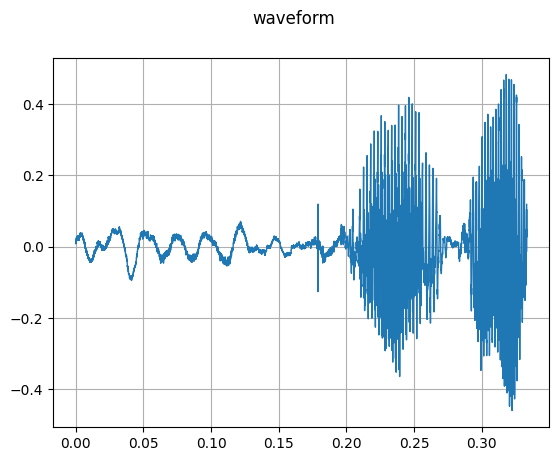

Target:


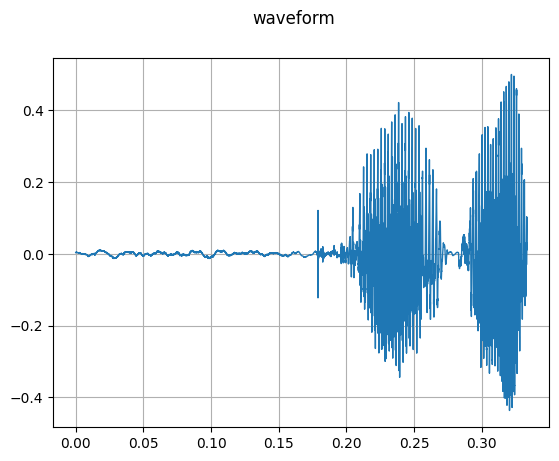

Output:


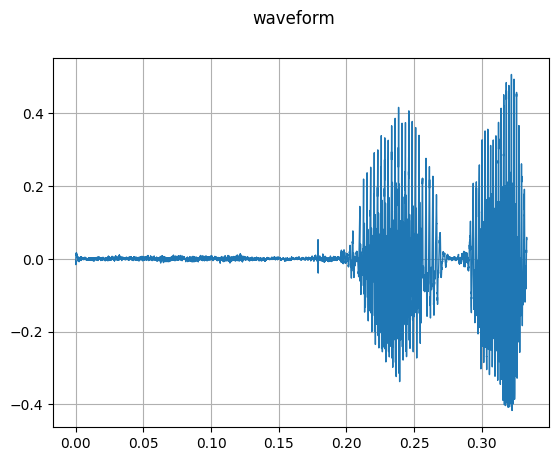

In [ ]:
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_d, srn)

In [ ]:
#@title E: sr=16000, num_frames=48000, l1
E = UNet(L=4).cuda()
more_losses_yay = train(E, 10, 1e-3, lfunc='l1', tr_loader=train_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.036
using time: 10.58 seconds
Start training epoch 2
[2/10] - loss: 0.026
using time: 18.31 seconds
Start training epoch 3
[3/10] - loss: 0.017
using time: 12.48 seconds
Start training epoch 4
[4/10] - loss: 0.013
using time: 9.16 seconds
Start training epoch 5
[5/10] - loss: 0.011
using time: 9.71 seconds
Start training epoch 6
[6/10] - loss: 0.011
using time: 11.76 seconds
Start training epoch 7
[7/10] - loss: 0.010
using time: 13.71 seconds
Start training epoch 8
[8/10] - loss: 0.010
using time: 13.72 seconds
Start training epoch 9
[9/10] - loss: 0.009
using time: 11.02 seconds
Start training epoch 10
[10/10] - loss: 0.009
using time: 10.52 seconds
time: 120.97 seconds


In [ ]:
noisy_test, srn = torchaudio.load('./noisy_test/p232_066.wav', num_frames=48000)
clean_test, src = torchaudio.load('./clean_test/p232_066.wav', num_frames=48000)
out_e = E(noisy_test.cuda())
out_e = out_e.detach().cpu().squeeze(1)
out_e

tensor([[0.0011, 0.0028, 0.0039,  ..., 0.0465, 0.0502, 0.0483]])

Original:


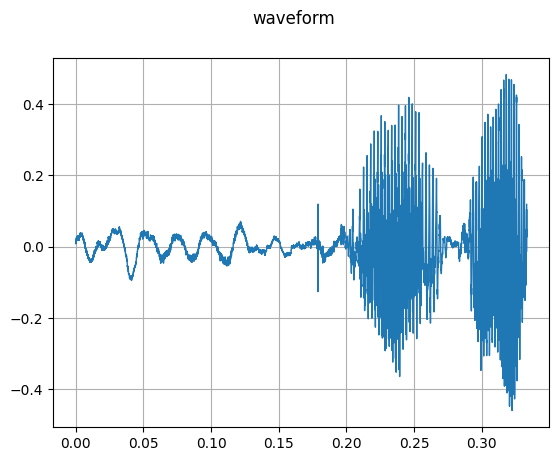

Target:


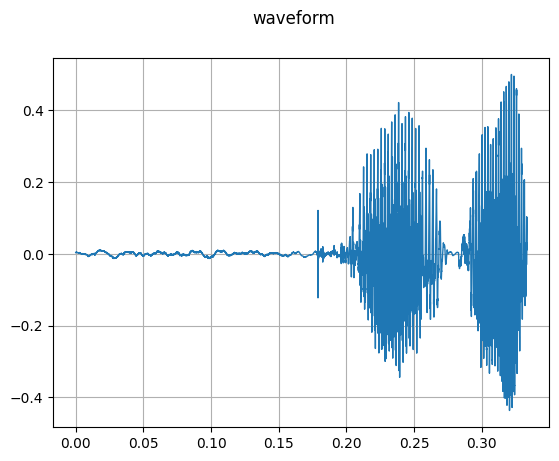

Output:


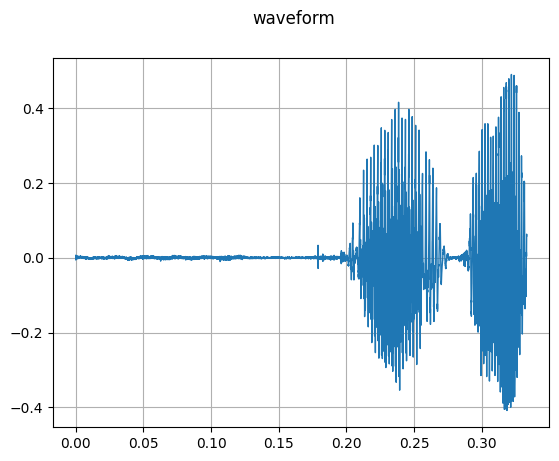

In [ ]:
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_e, srn)

In [ ]:
torch.save(D.state_dict(), '/content/drive/My Drive/Colab Notebooks/D.pth')

In [ ]:
torch.save(E.state_dict(), '/content/drive/My Drive/Colab Notebooks/E.pth')

In [ ]:
D.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/D.pth'))

<All keys matched successfully>

In [ ]:
E.eval()
D.eval()

E_scores = []
D_scores = []
E_k = []
D_k = []

for x in test_loader:
  noisy, clean = x
  noisy, clean = noisy.cuda(), clean.cuda()

  out_E = E(noisy)
  out_D = D(noisy)
  loss_E = MSE_loss(out_E, clean)
  loss_D = MSE_loss(out_D, clean)

  E_scores.append(loss_E.detach().item())
  D_scores.append(loss_D.detach().item())
  E_k.append(math.sqrt(len(x) * loss_E.detach().item()))
  D_k.append(math.sqrt(len(x) * loss_D.detach().item()))

avg_E_loss = np.mean(np.array(E_scores))
avg_D_loss = np.mean(np.array(D_scores))
avg_E_k = np.mean(np.array(E_k))
avg_D_k = np.mean(np.array(D_k))

print(f"E: {avg_E_loss:.5f}")
print(f"D: {avg_D_loss:.5f}")
print(f"E_2: {avg_E_k:.5f}")
print(f"D_2: {avg_D_k:.5f}")

E: 0.00022
D: 0.00025
E_2: 0.02037
D_2: 0.02170


In [ ]:
torchaudio.save('/content/drive/My Drive/Colab Notebooks/e.wav', out_e, 16000)
torchaudio.save('/content/drive/My Drive/Colab Notebooks/d.wav', out_d, 16000)

In [ ]:
G = UNet(L=4).cuda()
G.train()
f_losses = train(G, 10, 1e-3, lfunc='l1', tr_loader=train_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.040
using time: 11.93 seconds
Start training epoch 2
[2/10] - loss: 0.023
using time: 9.93 seconds
Start training epoch 3
[3/10] - loss: 0.017
using time: 8.46 seconds
Start training epoch 4
[4/10] - loss: 0.013
using time: 10.31 seconds
Start training epoch 5
[5/10] - loss: 0.012
using time: 8.14 seconds
Start training epoch 6
[6/10] - loss: 0.011
using time: 10.36 seconds
Start training epoch 7
[7/10] - loss: 0.010
using time: 9.53 seconds
Start training epoch 8
[8/10] - loss: 0.010
using time: 8.99 seconds
Start training epoch 9
[9/10] - loss: 0.010
using time: 10.94 seconds
Start training epoch 10
[10/10] - loss: 0.009
using time: 8.18 seconds
time: 96.79 seconds


Original:


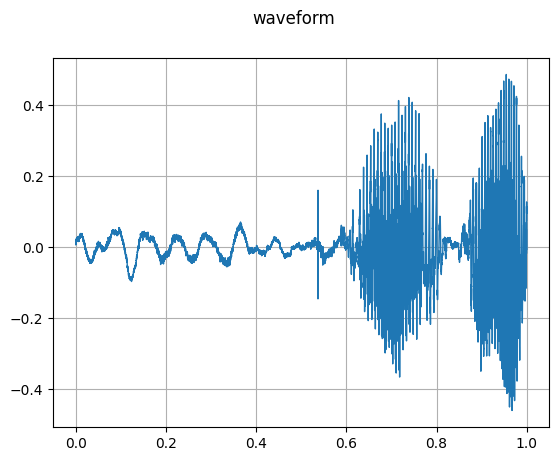

Target:


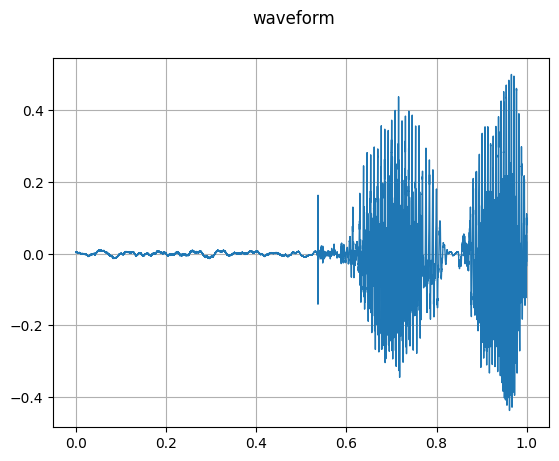

Output:


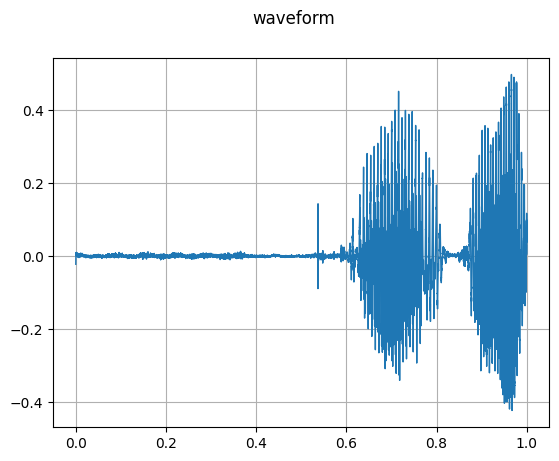

In [ ]:
out_g = G(noisy_test.cuda())
out_g = out_g.detach().cpu().squeeze(1)
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_g, srn)

In [ ]:
torchaudio.save('/content/drive/My Drive/Colab Notebooks/g.wav', out_g, 48000)

In [ ]:
torch.save(G.state_dict(), '/content/drive/My Drive/Colab Notebooks/G.pth')

In [ ]:
files = os.listdir('./noisy_train')
i = 96000
j = 100000
for f in files:
  ig = torchaudio.info('./noisy_train/' + f).num_frames
  t, a = torchaudio.load('./noisy_train/' + f)
  if ig < i: i = ig
  if t.shape[-1] < j: j = t.shape[-1]
print(i)
print(j)

59403
59403


In [ ]:
#@title H: sr=48000, num_frames=58000, l1

H = UNet(L=4).cuda()
H.train()
f_losses = train(H, 10, 1e-3, lfunc='l1', tr_loader=train_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.041
using time: 10.96 seconds
Start training epoch 2
[2/10] - loss: 0.025
using time: 8.88 seconds
Start training epoch 3
[3/10] - loss: 0.016
using time: 11.57 seconds
Start training epoch 4
[4/10] - loss: 0.014
using time: 10.62 seconds
Start training epoch 5
[5/10] - loss: 0.012
using time: 9.71 seconds
Start training epoch 6
[6/10] - loss: 0.012
using time: 11.21 seconds
Start training epoch 7
[7/10] - loss: 0.011
using time: 10.35 seconds
Start training epoch 8
[8/10] - loss: 0.010
using time: 10.06 seconds
Start training epoch 9
[9/10] - loss: 0.010
using time: 10.89 seconds
Start training epoch 10
[10/10] - loss: 0.010
using time: 10.39 seconds
time: 104.64 seconds


Original:


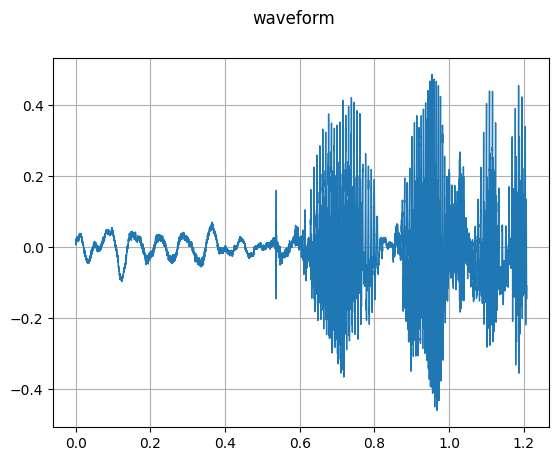

Target:


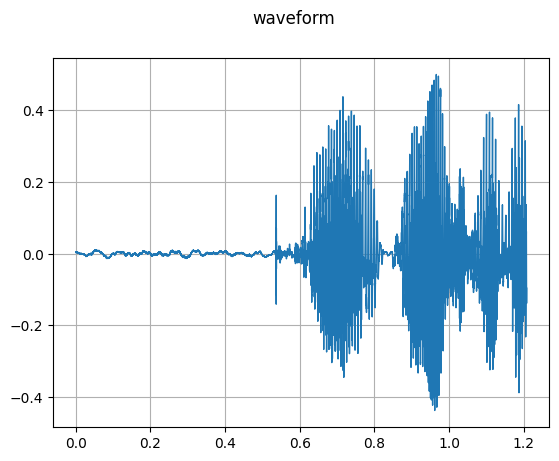

Output:


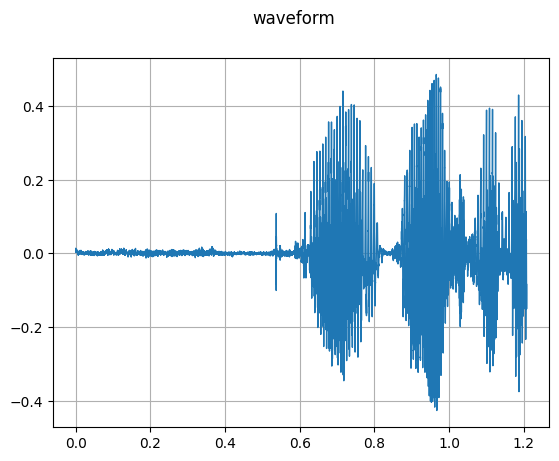

In [ ]:
noisy_test, srn = torchaudio.load('./noisy_test/p232_066.wav', num_frames=58000)
clean_test, src = torchaudio.load('./clean_test/p232_066.wav', num_frames=58000)
out_h = H(noisy_test.cuda())
out_h = out_h.detach().cpu().squeeze(1)
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_h, srn)

In [ ]:
torch.save(H.state_dict(), '/content/drive/My Drive/Colab Notebooks/H.pth')

In [ ]:
#@title J: sr=48000, num_frames=58000, l1

J = UNet(L=5).cuda()

In [ ]:
J.train()
f_losses = train(J, 20, 1e-3, lfunc='l1', tr_loader=train_loader)

training (help)
Start training epoch 1
[1/20] - loss: 0.044
using time: 15.61 seconds
Start training epoch 2
[2/20] - loss: 0.024
using time: 8.90 seconds
Start training epoch 3
[3/20] - loss: 0.017
using time: 10.86 seconds
Start training epoch 4
[4/20] - loss: 0.013
using time: 11.60 seconds
Start training epoch 5
[5/20] - loss: 0.012
using time: 9.32 seconds
Start training epoch 6
[6/20] - loss: 0.011
using time: 11.95 seconds
Start training epoch 7
[7/20] - loss: 0.011
using time: 10.45 seconds
Start training epoch 8
[8/20] - loss: 0.011
using time: 9.20 seconds
Start training epoch 9
[9/20] - loss: 0.010
using time: 11.12 seconds
Start training epoch 10
[10/20] - loss: 0.010
using time: 9.84 seconds
Start training epoch 11
[11/20] - loss: 0.010
using time: 9.98 seconds
Start training epoch 12
[12/20] - loss: 0.010
using time: 10.75 seconds
Start training epoch 13
[13/20] - loss: 0.010
using time: 8.85 seconds
Start training epoch 14
[14/20] - loss: 0.010
using time: 11.11 seconds


In [ ]:
torch.save(J.state_dict(), '/content/drive/My Drive/Colab Notebooks/J.pth')

In [ ]:
J.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/J.pth'))

<All keys matched successfully>

Original:


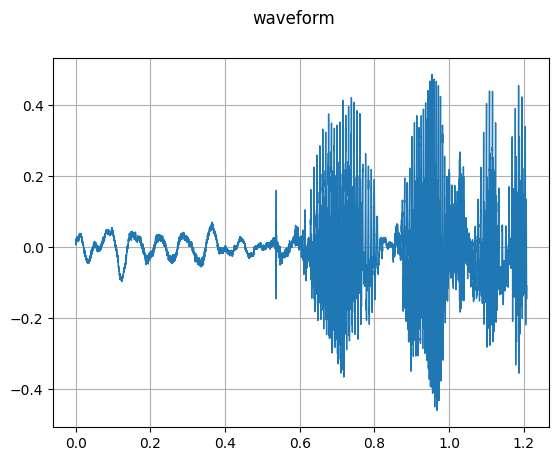

Target:


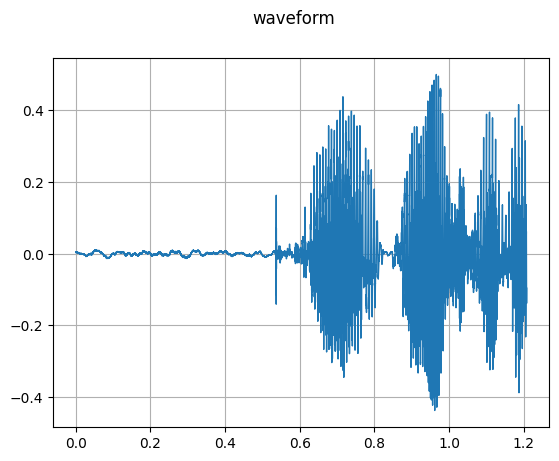

Output:


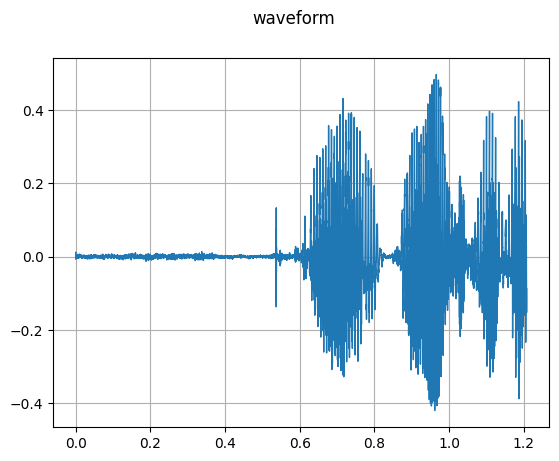

In [ ]:
noisy_test, srn = torchaudio.load('./noisy_test/p232_066.wav', num_frames=58000)
clean_test, src = torchaudio.load('./clean_test/p232_066.wav', num_frames=58000)
out_j = J(noisy_test.cuda())
out_j = out_j.detach().cpu().squeeze(1)
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_j, srn)

In [ ]:
def eval_model(model, test_loader):
  model.eval()

  scores1 = []
  scores2 = []

  for x in test_loader:
    noisy, clean = x
    noisy, clean = noisy.cuda(), clean.cuda()

    out = model(noisy)
    loss = MSE_loss(out, clean)

    scores1.append(loss.detach().item())
    scores2.append(math.sqrt(len(x) * loss.detach().item()))

  avg_loss = np.mean(np.array(scores1))
  avg_other = np.mean(np.array(scores2))

  print(f"Avg MSE loss: {avg_loss:.5f}")
  print(f"other: {avg_other:.5f}")

In [ ]:
LoudModel = UNet(L=6).cuda()

In [ ]:
env_train = ClipAudio('./env_ntrain', './env_ctrain', s_rate=40000, length=1.6, start=100)
env_test = ClipAudio('./env_ntest', './env_ctest', s_rate=40000, length=1.6, start=100)
env_tr_loader = DataLoader(env_train, batch_size=40, shuffle=True)
env_tt_loader = DataLoader(env_test, batch_size=40, shuffle=False)

In [ ]:
len(env_train)

658

In [ ]:
# ! pip install -U jax jaxlib

In [ ]:
losses = train(LoudModel, 10, lr=1e-3, lfunc='l1', tr_loader=env_tr_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.035
using time: 25.39 seconds
Start training epoch 2
[2/10] - loss: 0.030
using time: 24.56 seconds
Start training epoch 3
[3/10] - loss: 0.025
using time: 26.73 seconds
Start training epoch 4
[4/10] - loss: 0.022
using time: 29.07 seconds
Start training epoch 5
[5/10] - loss: 0.020
using time: 25.44 seconds
Start training epoch 6
[6/10] - loss: 0.018
using time: 24.15 seconds
Start training epoch 7
[7/10] - loss: 0.017
using time: 25.52 seconds
Start training epoch 8
[8/10] - loss: 0.016
using time: 25.44 seconds
Start training epoch 9
[9/10] - loss: 0.015
using time: 24.72 seconds
Start training epoch 10
[10/10] - loss: 0.015
using time: 24.85 seconds
time: 255.88 seconds


In [ ]:
L = UNet().cuda()
f_losses = train(L, 10, 1e-3, lfunc='l1', tr_loader=train_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.028
using time: 21.63 seconds
Start training epoch 2
[2/10] - loss: 0.013
using time: 23.76 seconds
Start training epoch 3
[3/10] - loss: 0.011
using time: 24.07 seconds
Start training epoch 4
[4/10] - loss: 0.010
using time: 23.14 seconds
Start training epoch 5
[5/10] - loss: 0.010
using time: 23.42 seconds
Start training epoch 6
[6/10] - loss: 0.009
using time: 23.57 seconds
Start training epoch 7
[7/10] - loss: 0.009
using time: 23.69 seconds
Start training epoch 8
[8/10] - loss: 0.009
using time: 22.53 seconds
Start training epoch 9
[9/10] - loss: 0.009
using time: 22.88 seconds
Start training epoch 10
[10/10] - loss: 0.009
using time: 23.11 seconds
time: 231.83 seconds


In [ ]:
eval_model(L, test_loader)

Avg MSE loss: 0.00021
other: 0.01942


In [ ]:
torch.save(L, '/content/drive/My Drive/Colab Notebooks/L.pth')

In [ ]:
torch.save(LoudModel, '/content/drive/My Drive/Colab Notebooks/Loud.pth')

In [ ]:
eval_model(LoudModel, env_tt_loader)

Avg MSE loss: 0.00080
other: 0.03981


In [140]:
1.6 * 48000

76800.0

Original:


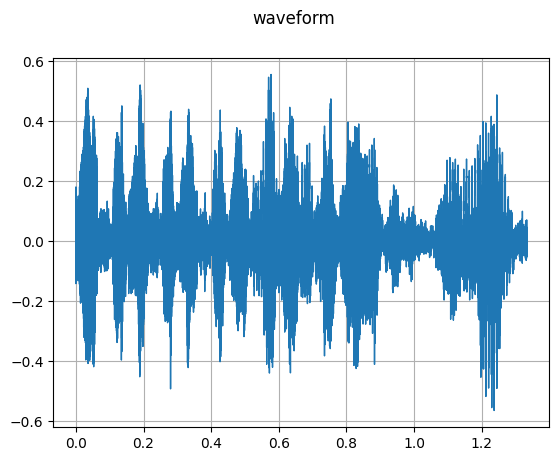

Target:


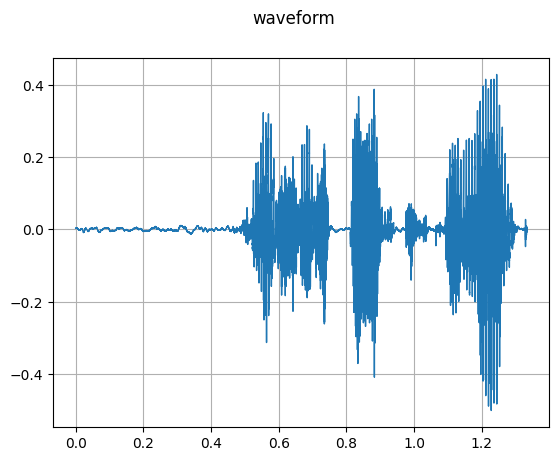

Output:


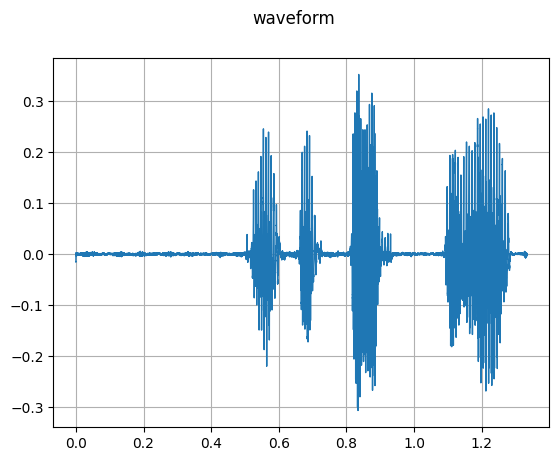

In [145]:
noisy_test, srn = torchaudio.load('./env_ntest/100038_p232_041.wav', num_frames=76800)
clean_test, src = torchaudio.load('./env_ctest/100038_p232_041.wav', num_frames=76800)
noisy_test = convert_audio(noisy_test, srn, 40000, 1)
clean_test = convert_audio(clean_test, src, 40000, 1)
out_ = LoudModel(noisy_test.cuda())
out_ = out_.detach().cpu().squeeze(1)
print("Original:")
plot_waveform(noisy_test, srn)
print("Target:")
plot_waveform(clean_test, srn)
print("Output:")
plot_waveform(out_, srn)

In [147]:
DModel = UNet(L=5).cuda()

In [148]:
losses = train(DModel, num_epochs=10, lr=1e-3, lfunc='l1', tr_loader=daps_tr_loader)

training (help)
Start training epoch 1
[1/10] - loss: 0.055
using time: 51.26 seconds
Start training epoch 2
[2/10] - loss: 0.051
using time: 53.33 seconds
Start training epoch 3
[3/10] - loss: 0.051
using time: 53.24 seconds
Start training epoch 4
[4/10] - loss: 0.051
using time: 52.09 seconds
Start training epoch 5
[5/10] - loss: 0.051
using time: 51.10 seconds
Start training epoch 6
[6/10] - loss: 0.051
using time: 54.45 seconds
Start training epoch 7
[7/10] - loss: 0.051
using time: 54.08 seconds
Start training epoch 8
[8/10] - loss: 0.051
using time: 51.74 seconds
Start training epoch 9
[9/10] - loss: 0.051
using time: 52.10 seconds
Start training epoch 10
[10/10] - loss: 0.051
using time: 53.95 seconds
time: 527.34 seconds


In [150]:
torch.save(DModel, '/content/drive/My Drive/Colab Notebooks/DModel.pth')

In [151]:
eval_model(DModel, daps_tt_loader)

Avg MSE loss: 0.01345
other: 0.16340
